In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# BEST MODEL dev_pt_24.01.25.0310.txt
# lora_model_re1

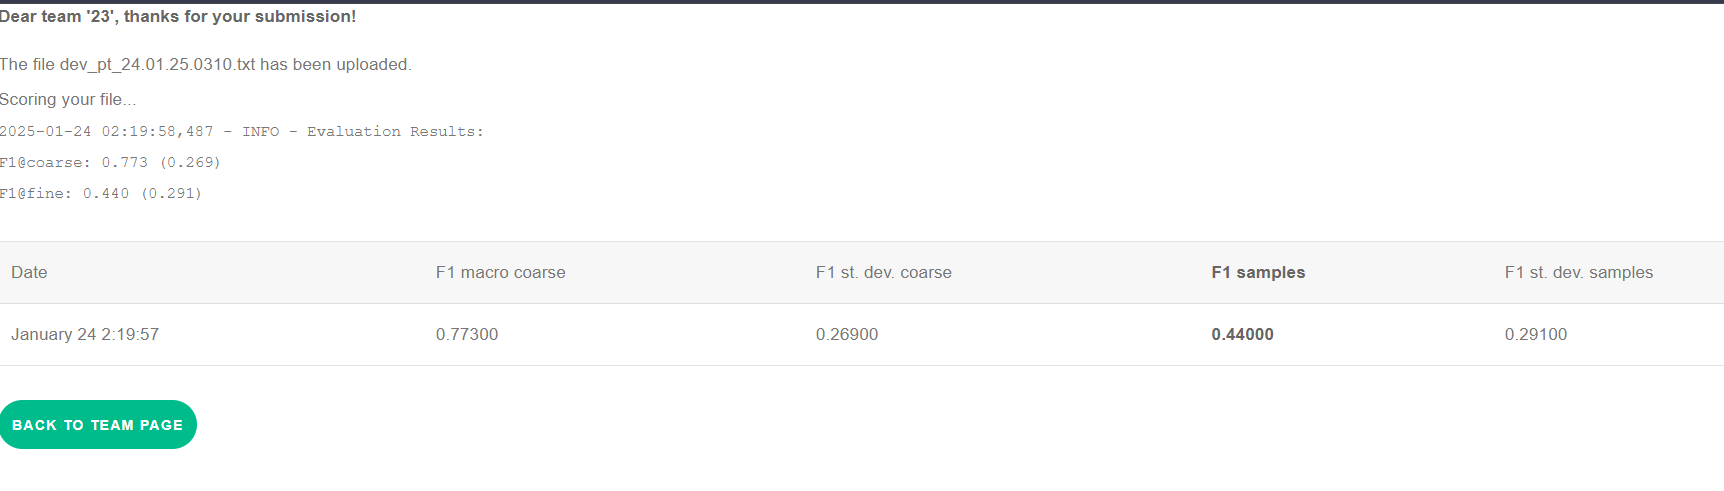

In [ ]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B", # unsloth/Meta-Llama-3.1-8B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.1.7: Fast Llama patching. Transformers: 4.47.1.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/content/drive/MyDrive/i2nlp_project/models/lora_model_re1", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Classify multi-class multi-label text

### Input:
{}

### Response:
"""

inputs = tokenizer(
[
    alpaca_prompt.format(
        "What is a famous tall tower in Paris?", # instruction
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256)

==((====))==  Unsloth 2025.1.7: Fast Llama patching. Transformers: 4.47.1.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Classify multi-class multi-label text

### Input:
What is a famous tall tower in Paris?

### Response:
1. Other
2. Other<|end_of_text|>


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128 # 16
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Already have LoRA adapters! We shall skip this step.


In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Classify multi-class multi-label text

### Input:
{}

### Response:
1. {}
2. {}
"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    inputs         = examples["input"]
    narratives     = examples["narrative"]
    sub_narratives = examples["sub_narrative"]
    texts = []
    for input, narrative, sub_narrative in zip(inputs, narratives, sub_narratives):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!

        text = alpaca_prompt.format(input.replace('\n', ' '), narrative, sub_narrative) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

from datasets import Dataset
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/i2nlp_project/dataset/augmented_train.csv') # train_all.csv
# df = df[df.language.isin(['EN', 'PT', 'HI'])]
dataset = Dataset.from_pandas(df[['text', 'narrative', 'sub_narrative']].rename({'text': 'input'}, axis=1))
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/1788 [00:00<?, ? examples/s]

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        # max_steps=100, # max_steps = 200,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Map (num_proc=2):   0%|          | 0/1788 [00:00<?, ? examples/s]

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.168 GB.
16.469 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,788 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 223
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,3.545000
2,3.877100
3,2.418900
4,2.527200
5,2.203000
6,2.448800
7,2.167600
8,1.871100
9,1.869900
10,2.032700


In [ ]:
model.save_pretrained("/content/drive/MyDrive/i2nlp_project/models/lora_model_re1.2") # Local saving
tokenizer.save_pretrained("/content/drive/MyDrive/i2nlp_project/models/lora_model_re1.2")

('/content/drive/MyDrive/i2nlp_project/models/lora_model_re1.1/tokenizer_config.json',
 '/content/drive/MyDrive/i2nlp_project/models/lora_model_re1.1/special_tokens_map.json',
 '/content/drive/MyDrive/i2nlp_project/models/lora_model_re1.1/tokenizer.json')

In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

945.4816 seconds used for training.
15.76 minutes used for training.
Peak reserved memory = 11.48 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 51.786 %.
Peak reserved memory for training % of max memory = 0.0 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

**[NEW] Try 2x faster inference in a free Colab for Llama-3.1 8b Instruct [here](https://colab.research.google.com/drive/1T-YBVfnphoVc8E2E854qF3jdia2Ll2W2?usp=sharing)**

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Classify multi-class multi-label text

### Input:
{}

### Response:
"""

# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        """Ukraine s Minerals: What the West is Fighting For \n\nWashington “cannot afford” to allow Russia to achieve victory in the Ukraine conflict as this would mean losing direct access to vast mineral assets. That was the view of US Senator Lindsey Graham* in an interview with ‘Face the Nation’ on CBS News in June. “They’re sitting on 10 to $12 trillion of critical minerals in Ukraine. They could be the richest country in all of Europe,  Graham said.  If we help Ukraine now, they can become the best business partner we ever dreamed of, that $10 to $12 trillion of critical mineral assets could be used by Ukraine and the West,” he added.Graham is treating Ukraine as a future colony of the US with his comments on the ownership of the country s natural resources, said Vladimir Dzhabarov, official of the Russian Federation Council. While  promising Ukrainians mountains of gold, Graham in fact considers it as a future American colony,  Dzhabarov said. *Lindsey Graham is included on the list of terrorists and extremists in Russia.Take a look at Sputnik s infographics to see Ukraine s mineral resources that the Westcotes so much.\n\nWest is fighting for, ukraine is rich in mineral resources\n\nUkraine s Minerals: What the West is Fighting For\n\nUkraine is rich in mineral resources, with diverse deposits of fossil fuels, metals and industrial minerals. The country is a major producer of iron ore, coal, natural gas and oil, among others.\n\nWashington “cannot afford” to allow Russia to achieve victory in the Ukraine conflict as this would mean losing direct access to vast mineral assets. That was the view of US Senator Lindsey Graham* in an interview with ‘Face the Nation’ on CBS News in June.\n\n“They’re sitting on 10 to $12 trillion of critical minerals in Ukraine. They could be the richest country in all of Europe,  Graham said.  If we help Ukraine now, they can become the best business partner we ever dreamed of, that $10 to $12 trillion of critical mineral assets could be used by Ukraine and the West,” he added.\n\nGraham is treating Ukraine as a future colony of the US with his comments on the ownership of the country s natural resources, said Vladimir Dzhabarov, official of the Russian Federation Council.\n\nWhile  promising Ukrainians mountains of gold, Graham in fact considers it as a future American colony,  Dzhabarov said.\n\n The fate of the colonies is always the same: the Americans will scoop up all the natural resources of Ukraine in exchange for  the great honor of being a friend of the United States ,  he warned.  Well, they will feed the corrupt top of the neo-Nazi regime in Kiev at the same time.
        """.replace('\n', ' '), # input
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Classify multi-class multi-label text

### Input:
Ukraine s Minerals: What the West is Fighting For   Washington “cannot afford” to allow Russia to achieve victory in the Ukraine conflict as this would mean losing direct access to vast mineral assets. That was the view of US Senator Lindsey Graham* in an interview with ‘Face the Nation’ on CBS News in June. “They’re sitting on 10 to $12 trillion of critical minerals in Ukraine. They could be the richest country in all of Europe,  Graham said.  If we help Ukraine now, they can become the best business partner we ever dreamed of, that $10 to $12 trillion of critical mineral assets could be used by Ukraine and the West,” he added.Graham is treating Ukraine as a future colony of the US with his comments on the ownership of the country s natural resou

# DEV & TEST EVAL

In [ ]:
def test_formatting_prompts_func(examples):
    inputs = examples["input"]
    texts = [alpaca_prompt.format(input.replace('\n', ' ')) for input in inputs]
    return {"text": texts}

from datasets import Dataset
import pandas as pd

dev_df = pd.read_csv('/content/drive/MyDrive/i2nlp_project/dataset/test_enpt.csv')
dev_dataset = Dataset.from_pandas(dev_df[['filename', 'text', 'narrative', 'sub_narrative', 'language']].rename({'text': 'input'}, axis=1))
dev_dataset = dev_dataset.map(test_formatting_prompts_func, batched = True,)

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

In [ ]:
from tqdm import tqdm
# Step 3: Generate outputs for each test input
results = []
FastLanguageModel.for_inference(model)

for example in tqdm(dev_dataset, desc="Generating Outputs", unit="sample"):
    filename = example["filename"]
    language = example["language"]
    input_text = example["text"]
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

    # Generate response
    generated_output = model.generate(
        **inputs,
        max_new_tokens=256,
        use_cache = True,  # Ensure EOS token usage
    )

    # Decode and save the output
    output_text = tokenizer.decode(generated_output[0], skip_special_tokens=True)
    results.append({"filename": filename, "language": language, "input": input_text, "output": output_text})

# Step 4: Save results as text or CSV
results_df = pd.DataFrame(results)

Generating Outputs: 100%|██████████| 76/76 [17:22<00:00, 13.72s/sample]


In [ ]:
from datetime import datetime

current_time = datetime.now()
time_save = current_time.strftime("%d.%m.%y.%H%M")

def clean_labels(label):
  return ';'.join(list(set([i.strip() for i in label.split(';')])))

results_df['narratives'] = results_df['output'].apply(lambda x: x.split('### Response:\n')[1].split('\n')[0].replace('1. ', '').strip())
results_df['sub_narratives'] = results_df['output'].apply(lambda x: x.split('### Response:\n')[1].split('\n')[1].replace('2. ', '').strip())

results_df['narratives'] = results_df['narratives'].apply(clean_labels)
results_df['sub_narratives'] = results_df['sub_narratives'].apply(clean_labels)

results_df[results_df.language == 'EN'][['filename', 'narratives', 'sub_narratives']]\
  .to_csv(f'/content/drive/MyDrive/i2nlp_project/predicted/dev_en_{time_save}.txt', index=False, sep='\t', header=None)
results_df[results_df.language == 'PT'][['filename', 'narratives', 'sub_narratives']]\
  .to_csv(f'/content/drive/MyDrive/i2nlp_project/predicted/dev_pt_{time_save}.txt', index=False, sep='\t', header=None)

In [ ]:
results_df

,filename,language,input,output,narratives,sub_narratives
0,EN_UA_DEV_100012.txt,EN,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",URW: Russia is the Victim;URW: Praise of Russi...,URW: Praise of Russia: Russia is a guarantor o...
1,EN_CC_200053.txt,EN,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",CC: Criticism of institutions and authorities;...,CC: Criticism of climate policies: Climate pol...
2,EN_CC_200040.txt,EN,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",CC: Hidden plots by secret schemes of powerful...,CC: Ad hominem: Blaming climate movement for a...
3,EN_CC_200070.txt,EN,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",CC: Criticism of institutions and authorities;...,CC: Criticism of climate policies: Climate pol...
4,EN_UA_DEV_100034.txt,EN,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",URW: Praise of Ukraine,URW: Praise of Ukraine: Ukraine is a bulwark o...
...,...,...,...,...,...,...
71,PT_207.txt,PT,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",CC: Criticism of institutions and authorities,CC: Criticism of institutions and authorities:...
72,PT_217.txt,PT,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",CC: Amplifying Climate Fears,CC: Amplifying Climate Fears: Amplifying exist...
73,PT_204.txt,PT,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",Other,Other
74,PT_229.txt,PT,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",CC: Amplifying Climate Fears,CC: Amplifying Climate Fears: Other


# TEST AND SUBMIT

In [ ]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/content/drive/MyDrive/i2nlp_project/models/lora_model_re1", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

==((====))==  Unsloth 2025.1.7: Fast Llama patching. Transformers: 4.47.1.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [ ]:
def test_formatting_prompts_func(examples):
    inputs = examples["input"]
    texts = [alpaca_prompt.format(input.replace('\n', ' ')) for input in inputs]
    return {"text": texts}

from datasets import Dataset
import pandas as pd

test_df = pd.read_csv('/content/drive/MyDrive/i2nlp_project/dataset/submit.csv')
test_dataset = Dataset.from_pandas(test_df[['filename', 'text', 'language']].rename({'text': 'input'}, axis=1))
test_dataset = test_dataset.map(test_formatting_prompts_func, batched = True,)

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

In [ ]:
from tqdm import tqdm
# Step 3: Generate outputs for each test input
results = []
text_streamer = TextStreamer(tokenizer)  # Optional: Stream outputs to console

for example in tqdm(test_dataset, desc="Generating Outputs", unit="sample"):
    filename = example["filename"]
    language = example["language"]
    input_text = example["text"]
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

    # Generate response
    generated_output = model.generate(
        **inputs,
        max_new_tokens=256,
        eos_token_id=tokenizer.eos_token_id,  # Ensure EOS token usage
    )

    # Decode and save the output
    output_text = tokenizer.decode(generated_output[0], skip_special_tokens=True)
    results.append({"filename": filename, "language": language, "input": input_text, "output": output_text})

# Step 4: Save results as text or CSV
results_df = pd.DataFrame(results)

Generating Outputs: 100%|██████████| 201/201 [51:45<00:00, 15.45s/sample]


In [ ]:
# def clean_labels(label):
#   return ';'.join(list(set([i.strip() for i in label.split(';')])))

results_df['narratives'] = results_df['output'].apply(lambda x: x.split('### Response:\n')[1].split('\n')[0].replace('1. ', '').strip())
results_df['sub_narratives'] = results_df['output'].apply(
    lambda x: (
        x.split('### Response:\n')[1].split('\n')[1].replace('2. ', '').strip()
        if '### Response:\n' in x and len(x.split('### Response:\n')[1].split('\n')) > 1
        else 'Other'
    )
)

results_df['narratives'] = results_df['narratives'].apply(clean_labels)
results_df['sub_narratives'] = results_df['sub_narratives'].apply(clean_labels)

def clean_labels(label):
  return ';'.join(list(set([i.strip() for i in label.split(',')[1:-1]])))

results_df[results_df.language == 'EN'][['filename', 'narratives', 'sub_narratives']]\
  .to_csv(f'/content/drive/MyDrive/i2nlp_project/predicted/test_en_{time_save}.txt', index=False, sep='\t', header=None)
results_df[results_df.language == 'PT'][['filename', 'narratives', 'sub_narratives']]\
  .to_csv(f'/content/drive/MyDrive/i2nlp_project/predicted/test_pt_{time_save}.txt', index=False, sep='\t', header=None)

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
# model.save_pretrained("/content/drive/MyDrive/i2nlp_project/models/lora_model") # Local saving
# tokenizer.save_pretrained("/content/drive/MyDrive/i2nlp_project/models/lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('/content/drive/MyDrive/i2nlp_project/models/lora_model/tokenizer_config.json',
 '/content/drive/MyDrive/i2nlp_project/models/lora_model/special_tokens_map.json',
 '/content/drive/MyDrive/i2nlp_project/models/lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# alpaca_prompt = You MUST copy from above!

inputs = tokenizer(
[
    alpaca_prompt.format(
        "What is a famous tall tower in Paris?", # instruction
        "", # input
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
What is a famous tall tower in Paris?

### Input:


### Response:
One of the most famous and iconic tall towers in Paris is the Eiffel Tower. Standing at 324 meters (1,063 feet) tall, this wrought iron tower is a symbol of the city and a must-see attraction for tourists from all over the world.<|end_of_text|>


You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")